In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt # Module for plotting
import seaborn as sns # Module for plotting
from datetime import datetime  # Module for working with dates and time

In [2]:
!pip freeze > requirements.txt

In [3]:
pd.set_option('display.max_rows', 250)  # Show more rows
pd.set_option('display.max_columns', 250)  # Show more columns

pd.set_option('display.max_rows', 250)  # Show more rows
pd.set_option('display.max_columns', 250)  # Show more columns

# Dictionary of fuel consumption and fuel cost percent (of full cost) by month
gsm_cost = {
    1: [41435, 0.2175],
    2: [39553, 0.2],
    12: [47101, 0.21]
}

# List of columns with data
date_columns = ['scheduled_departure', 'scheduled_arrival', 'actual_departure', 'actual_arrival']

In [4]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)

    percentile_.__name__ = 'Q_%s' % (n // 25)
    return percentile_

In [5]:

# Creating class for computing statistics of flights
class flight_stat():

    global gsm_cost, date_columns

    # Create initiating parts
    def __init__(self):
        self.frame = pd.read_csv('./flights_data_set.csv') # read the file with dataset

        # Reform columns with data into datetime format
        for column in date_columns:
            self.frame[column] = self.frame[column].apply(lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ'))

        # Creating a set with aircrafts and it properties
        self.aircrafts = pd.read_csv('./aircrafts.csv', sep=';')

        # Creating the additional columns
        self.frame['actual_flight_time'] = self.frame['actual_arrival'] - self.frame['actual_departure']
        self.frame['actual_flight_time'] = self.frame['actual_flight_time'].apply(lambda x: x.total_seconds()/60)
        self.frame['scheduled_flight_time'] = self.frame['scheduled_arrival'] - self.frame['scheduled_departure']
        self.frame['scheduled_flight_time'] = self.frame['scheduled_flight_time'].apply(lambda x: x.total_seconds() / 60)
        self.frame['departure_delay'] = self.frame['scheduled_departure'] - self.frame['actual_departure']
        self.frame['departure_delay'] = self.frame['departure_delay'].apply(lambda x: x.total_seconds() / 60)
        self.frame['arrival_delay'] = self.frame['scheduled_arrival'] - self.frame['actual_arrival']
        self.frame['arrival_delay'] = self.frame['arrival_delay'].apply(lambda x: x.total_seconds() / 60)
        self.frame['schedule_flight_cost'] = self.frame.apply(lambda row: self.full_cost(row, 'schedule'), axis=1)
        self.frame['actual_flight_cost'] = self.frame.apply(lambda row: self.full_cost(row, 'actual'), axis=1)
        self.frame['flight_profit'] = self.frame['actual_amount_sum'] - self.frame['actual_flight_cost']
        self.frame['month'] = self.frame['actual_departure'].apply(lambda x: x.month)
        self.frame['flight_weekday'] = self.frame['actual_departure'].apply(lambda x: x.strftime('%A'))

        # Initiating the dataframe with race statistics
        self.races = pd.DataFrame()
        self.races['races'] = self.frame['flight_no'].value_counts().values
        self.races.index = self.frame['flight_no'].value_counts().index
        for race in self.races.index:
            self.races.at[race, 'model'] = self.frame[self.frame['flight_no'] == race]['model'].values[0]

    # Function for computing full coast of race
    def full_cost(self, row, type_):

        # Preparing branch that will be used in function
        if type_ == 'schedule':
            control_columns = ['scheduled_departure', 'scheduled_arrival', 'scheduled_flight_time']
        else:
            control_columns = ['actual_departure', 'actual_arrival', 'actual_flight_time']
        # Fuel cost for flight with tax
        gsm_flight_cost = gsm_cost[row[control_columns[0]].month][0] * 1.18
        # Fuel consumption in tons
        gsm_consumption = self.aircrafts[self.aircrafts['model'] == row['model']]['fuel_consumption'] / 1000
        # Computing flight time in hours
        flight_time = row[control_columns[2]] / 60

        # Computing total flight coast in next formula: tc=fuel_cost/(percent_of_tc) where:
        # fuel_cost = flight time (hours) * fuel consumption (tons per hours) * fuel_cost (rub per tons)
        # percent_of_tc = fuel percent of summary cost of race (by ria.ru data)
        total_cost = round((gsm_flight_cost * gsm_consumption * flight_time).values[0] /
                            gsm_cost[row[control_columns[0]].month][1], 2)

        return total_cost

    # Object for flight profit boxplot plotting
    def showing_flights(self):

        # Generate plotting area and axis parameters
        fig, axes = plt.subplots(ncols=1, nrows=2, gridspec_kw={'height_ratios': [12, 1]})
        axes[0].set_title(f'Boxplot of profit by race')
        axes[0].xaxis.set_label_position('top')
        axes[0].xaxis.tick_top()
        axes[1].axis('tight')
        axes[1].axis('off')

        # Generate the statistics parameters table ana
        column_stats = self.frame.groupby(by='flight_no')['flight_profit'].agg(['count', 'mean', 'std', 'median',
                                                                                'min', 'max', percentile(25),
                                                                                percentile(75)])

        # Create table object in plotting area
        table = axes[1].table(cellText=np.round(column_stats.values.tolist(), 1),
                              colLabels=column_stats.columns,
                              rowLabels=column_stats.index)
        # Configure table parameters
        table.auto_set_font_size(False)
        table.set_fontsize(11)

        # Configure boxplot object and it parameters
        sns.boxplot(ax=axes[0],
                    x='flight_no',
                    y='flight_profit',
                    data=self.frame,
                    )
        # Show the plotting area
        plt.show()

    # Object for generating races statistics table
    def stat(self):

        # Common statistics of races profit
        display(self.frame.groupby('flight_no')['flight_profit'].describe())

        # Statistics of weekday divided by month
        months_ = self.frame['month'].unique()
        week_days = self.frame['flight_weekday'].unique()

        # Generate race statistics by month and weekday
        for month in months_:

            self.races.loc[:, str(month) + '_costs'] = 0  # race cost
            self.races.loc[:, str(month) + '_mean_dep_delay'] = 0  # mean departure delay
            self.races.loc[:, str(month) + '_max_dep_delay'] = 0  # max departure delay
            self.races.loc[:, str(month) + '_max_dep_delay_day'] = 0  # max departure delay day
            self.races.loc[:, str(month) + '_mean_ft_dif'] = 0  # mean flight time difference
            self.races.loc[:, str(month) + '_max_ft_dif'] = 0  # max flight time difference
            self.races.loc[:, str(month) + '_max_ft_day'] = 0  # max flight time day

            for day in week_days:

                self.races.loc[:, str(month) + '_' + day + '_profit'] = None  # Mean profit combine by month and day
                self.races.loc[:, str(month) + '_' + day + 'bc_percent'] = None  # Mean percent of business class boarding
                self.races.loc[:, str(month) + '_' + day + 'ec_percent'] = None  # Mean percent of economy class boarding
                for race in self.races.index:

                    indexes = self.frame[(self.frame['month'] == month)
                                         & (self.frame['flight_weekday'] == day)
                                         & (self.frame['flight_no'] == race)].index
                    try:
                        self.races.at[race, str(month) + '_' + day + '_profit'] = \
                            self.frame.loc[indexes, 'flight_profit'].mean()
                        race_bc = self.frame.loc[indexes, 'buisness_ticket_count'].mean()
                        race_ec = self.frame.loc[indexes, 'economy_ticket_count'].mean()
                        ac_ind = self.aircrafts[self.aircrafts['model'] == self.races.loc[race, 'model']].index
                        ac_bc = self.aircrafts.loc[ac_ind, 'business_ticket_count'].values[0]
                        ac_ec = self.aircrafts.loc[ac_ind, 'economy_ticket_count'].values[0]

                        self.races.at[race, str(month) + '_' + day + '_bc_percent'] = (race_bc / ac_bc) * 100
                        self.races.at[race, str(month) + '_' + day + '_ec_percent'] = (race_ec / ac_ec) * 100

                    except ValueError:
                        self.races.at[race, str(month) + '_' + day + '_profit'] = None

            for race in self.races.index:

                indexes = self.frame[(self.frame['month'] == month)
                                     & (self.frame['flight_no'] == race)].index
                self.races.at[race, str(month) + '_costs'] = self.frame.loc[indexes, 'actual_flight_cost'].mean()
                self.races.loc[race, str(month) + '_mean_dep_delay'] = self.frame.loc[indexes, 'departure_delay'].mean()
                self.races.loc[race, str(month) + '_max_dep_delay'] = self.frame.loc[indexes, 'departure_delay'].min()
                max_index = self.frame.loc[indexes, 'departure_delay'].min()
                max_index = self.frame.loc[indexes][self.frame.loc[indexes, 'departure_delay'] == max_index].index
                self.races.loc[race, str(month) + '_max_dep_delay_day'] = \
                                                            self.frame.loc[max_index, 'scheduled_departure'].values[0]
                self.races.loc[race, str(month) + '_mean_ft_dif'] = self.frame.loc[indexes, 'actual_flight_time'].mean()
                self.races.loc[race, str(month) + '_max_ft_dif'] = self.frame.loc[indexes, 'actual_flight_time'].max()
                max_dif = self.frame.loc[indexes, 'actual_flight_time'].max()
                max_dif_index = self.frame.loc[indexes][self.frame.loc[indexes, 'actual_flight_time'] == max_dif].index

                self.races.loc[race, str(month) + '_max_ft_day'] = \
                                                        self.frame.loc[max_dif_index, 'scheduled_departure'].values[0]

        display(self.races)

    # Object for writing data tables into files
    def write_file(self):
        self.frame.to_excel('result_table.xlsx')
        self.races.to_excel('races_table.xlsx')

In [6]:
flight_set = flight_stat()

In [7]:
flight_set.stat()


,count,mean,std,min,25%,50%,75%,max
flight_no,,,,,,,,
PG0194,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PG0252,59.0,652498.437966,138603.834076,386449.25,546064.930,652761.63,748762.315,911880.61
PG0480,59.0,385666.483220,65623.445743,200402.84,339635.745,415802.84,434702.840,453207.13


,races,model,1_costs,1_mean_dep_delay,1_max_dep_delay,1_max_dep_delay_day,1_mean_ft_dif,1_max_ft_dif,1_max_ft_day,1_Tuesday_profit,1_Tuesdaybc_percent,1_Tuesdayec_percent,1_Tuesday_bc_percent,1_Tuesday_ec_percent,1_Friday_profit,1_Fridaybc_percent,1_Fridayec_percent,1_Friday_bc_percent,1_Friday_ec_percent,1_Sunday_profit,1_Sundaybc_percent,1_Sundayec_percent,1_Sunday_bc_percent,1_Sunday_ec_percent,1_Monday_profit,1_Mondaybc_percent,1_Mondayec_percent,1_Monday_bc_percent,1_Monday_ec_percent,1_Saturday_profit,1_Saturdaybc_percent,1_Saturdayec_percent,1_Saturday_bc_percent,1_Saturday_ec_percent,1_Wednesday_profit,1_Wednesdaybc_percent,1_Wednesdayec_percent,1_Wednesday_bc_percent,1_Wednesday_ec_percent,1_Thursday_profit,1_Thursdaybc_percent,1_Thursdayec_percent,1_Thursday_bc_percent,1_Thursday_ec_percent,2_costs,2_mean_dep_delay,2_max_dep_delay,2_max_dep_delay_day,2_mean_ft_dif,2_max_ft_dif,2_max_ft_day,2_Tuesday_profit,2_Tuesdaybc_percent,2_Tuesdayec_percent,2_Tuesday_bc_percent,2_Tuesday_ec_percent,2_Friday_profit,2_Fridaybc_percent,2_Fridayec_percent,2_Friday_bc_percent,2_Friday_ec_percent,2_Sunday_profit,2_Sundaybc_percent,2_Sundayec_percent,2_Sunday_bc_percent,2_Sunday_ec_percent,2_Monday_profit,2_Mondaybc_percent,2_Mondayec_percent,2_Monday_bc_percent,2_Monday_ec_percent,2_Saturday_profit,2_Saturdaybc_percent,2_Saturdayec_percent,2_Saturday_bc_percent,2_Saturday_ec_percent,2_Wednesday_profit,2_Wednesdaybc_percent,2_Wednesdayec_percent,2_Wednesday_bc_percent,2_Wednesday_ec_percent,2_Thursday_profit,2_Thursdaybc_percent,2_Thursdayec_percent,2_Thursday_bc_percent,2_Thursday_ec_percent
PG0252,59,Boeing 737-300,971291,-9.419355,-207,2017-01-24T10:05:00.000000000,99.709677,103,2017-01-14T10:05:00.000000000,720360.612,None,None,86.666667,90.847458,720336.5075,None,None,89.583333,89.406780,569553.568,None,None,83.333333,80.847458,640068.852,None,None,81.666667,86.610169,713330.615,None,None,91.666667,88.771186,677065.9125,None,None,89.583333,86.864407,767930.615,None,None,97.916667,90.677966,1010877,-3.071429,-8,2017-02-11T10:05:00.000000000,99.964286,101,2017-02-22T10:05:00.000000000,713917.825,None,None,89.583333,91.737288,693389.7275,None,None,93.750000,89.194915,537239.7275,None,None,89.583333,79.661017,629861.6325,None,None,87.500000,86.864407,635961.63,None,None,89.583333,86.652542,578233.5375,None,None,83.333333,84.745763,544605.44,None,None,75.000000,85.169492
PG0480,59,Sukhoi Superjet-100,319078,-14.483871,-197,2017-01-07T09:25:00.000000000,50.096774,51,2017-01-07T09:25:00.000000000,393650.194,None,None,91.666667,94.117647,401197.51,None,None,89.583333,95.294118,390004.042,None,None,93.333333,92.470588,343010.194,None,None,88.333333,86.117647,398970.58,None,None,93.750000,94.117647,424787.89,None,None,100.000000,95.882353,410630.2,None,None,93.750000,95.588235,331069,-3.214286,-8,2017-02-04T09:25:00.000000000,50.071429,51,2017-02-15T09:25:00.000000000,345974.855,None,None,83.333333,90.882353,365252.84,None,None,91.666667,90.588235,373049.855,None,None,91.666667,92.352941,404933.81,None,None,95.833333,95.588235,384224.855,None,None,93.750000,93.529412,429821.87,None,None,100.000000,99.705882,341405.825,None,None,85.416667,88.529412
PG0194,9,Boeing 737-300,2980805,-2.800000,-4,2017-01-10T06:10:00.000000000,306.000000,312,2017-01-10T06:10:00.000000000,NaN,None,None,NaN,NaN,NaN,None,None,NaN,NaN,NaN,None,None,NaN,NaN,NaN,None,None,NaN,NaN,NaN,None,None,NaN,NaN,NaN,None,None,NaN,NaN,NaN,None,None,NaN,NaN,3109557,-3.500000,-5,2017-02-21T06:10:00.000000000,307.500000,311,2017-02-14T06:10:00.000000000,NaN,None,None,NaN,NaN,NaN,None,None,NaN,NaN,NaN,None,None,NaN,NaN,NaN,None,None,NaN,NaN,NaN,None,None,NaN,NaN,NaN,None,None,NaN,NaN,NaN,None,None,NaN,NaN


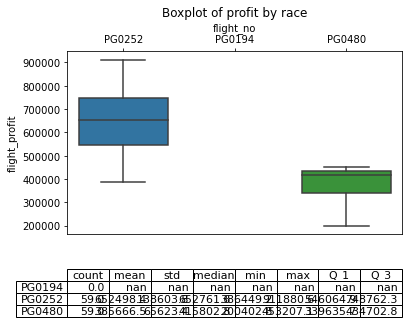

In [8]:
flight_set.showing_flights()


In [9]:
flight_set.write_file()